### 公众号：数据不吹牛，更多案例和有趣分析等你来撩

In [ ]:
import pandas as pd
from selenium import webdriver
import random
import os
import time

### 爬取单页评价（每页20条）

In [216]:
def get_page(driver):
    
    result = pd.DataFrame()
    for i in driver.find_elements_by_xpath('//div[@class = "rate-grid"]/table/tbody/tr'):
        try:
            content = i.find_element_by_xpath('td[@class = "tm-col-master"]/div[@class = "tm-rate-content"]').text
            #评价日期
            date = i.find_element_by_xpath('td[@class = "tm-col-master"]/div[@class = "tm-rate-date"]').text
            #购买产品
            sku = i.find_element_by_xpath('td[@class = "col-meta"]/div[@class = "rate-sku"]').text

            #用户名
            username = i.find_element_by_xpath('td[@class = "col-author"]/div[@class = "rate-user-info"]').text
            append_time = None
            append_content = None

        except:
            content = i.find_element_by_xpath('td[@class = "tm-col-master"]/div[@class = "tm-rate-premiere"]/div[@class = "tm-rate-content"]').text
            #评价日期
            date = i.find_element_by_xpath('td[@class = "tm-col-master"]/div[@class = "tm-rate-premiere"]/div[@class = "tm-rate-tag"]/div[@class = "tm-rate-date"]').text
            #购买产品
            sku = i.find_element_by_xpath('td[@class = "col-meta"]/div[@class = "rate-sku"]').text
            #用户名
            username = i.find_element_by_xpath('td[@class = "col-author"]/div[@class = "rate-user-info"]').text

            append_time = i.find_element_by_xpath('td[@class = "tm-col-master"]/div[@class = "tm-rate-append"]/div[1]').text
            append_content = i.find_element_by_xpath('td[@class = "tm-col-master"]/div[@class = "tm-rate-append"]/div[2]').text

        df = pd.DataFrame({'用户名':[username],'购买产品':[sku],'评价日期':[date],'初评内容':[content],
                         '追评时间':[append_time],'追评内容':[append_content]})

        result = pd.concat([result,df])
    
    return result,driver

### 循环爬取，需要提前指定网址和评论总数

In [107]:
url = 'https://detail.tmall.com/item.htm?spm=a230r.1.14.1.70f65edadaPTn3&id=521921506095&ns=1&abbucket=18'

def carwl_product_comment(driver,url,max_num = 100):
    driver.get(url)
    
    time.sleep(5)
    #关掉要求登录的弹窗，就能够不登录状态下爬取
    driver.find_element_by_xpath('//div[@class = "sufei-dialog-close"]').click()
    
    driver.implicitly_wait(5)
    #点击到评论页面
    try:
        driver.find_element_by_xpath('//ul[@class = "tabbar tm-clear"]/li[2]').click()
    except:
        driver.implicitly_wait(5)
        driver.find_element_by_xpath('//ul[@class = "tabbar tm-clear"]/li[2]').click()
        
    max_page = int(max_num / 20)
    
    if max_page > 90:
        max_page = 90
    else:
        pass
    
    c = 1
    final_re = pd.DataFrame()

    while c <= max_page:
        result,driver = get_page(driver)
        final_re = pd.concat([final_re,result])
        print('Bro，完成第{}页爬取'.format(c))

        #点击下一页
        driver.find_element_by_link_text('下一页>>').click()
        c += 1
        time.sleep(random.random() + 3)
    return final_re

### 运行
#### 这里使用的是selenium中的PhantomJS，同学们也可以尝试Chrome，安装坑略多，不过网上都能找到相关解决方法

In [217]:
driver = webdriver.PhantomJS()
final_re = carwl_product_comment(driver,url)

### 情感分词

In [208]:
from snownlp import SnowNLP

sens = []

for text in final_re['初评内容']:
    s = SnowNLP(text)
    sens.append(s.sentiments)
    
final_re['初评情感评分'] = sens

,品牌,买家,评价日期,初评内容,追评,SKU
0,三个魔发匠,t**4,2019-11-21,用了之后真的是促进每个神经细胞的，洗发水的泡沫比较丰富的，不需要拿沐浴球搓，随便用手搓搓就可...,姗姗来迟的生姜洗发水，在关键时刻起到了最大的作用，洗头发顺顺滑滑的，特别清新，留香持久，洗的...,化妆品净含量：(2瓶）生姜洗发水500ml+500ml
1,三个魔发匠,t**3,2019-11-23,生姜洗发水用着很舒服，根据使用方法来洗一个地方就按一次，把头皮都按了个遍，很舒服，而且泡泡很...,淡淡的姜香味，闻着挺舒服的，而且这个控油去屑的效果真是无敌，不用再看到满头的头皮屑的感觉真好...,化妆品净含量：（1瓶）生姜洗发水500ml
2,三个魔发匠,喃**y,2019-11-22,朋友推荐来买的这款生姜洗发水，根据她们说效果很好！生姜发水一大瓶超级划算，九零后已经走上了防...,我闻着洗发水有很浓的生姜味道，但又不会很刺鼻，蛮好的，洗发后头皮不痒、没有头皮屑，至于生发效...,化妆品净含量：（1瓶）生姜洗发水500ml
3,三个魔发匠,f**0,2019-11-22,脱发的故事是缓缓写到结局，这款生姜洗发水是生姜提取物成分，使用也是非常的放心，而且这款洗发水...,唠唠叨叨的用这款洗发水洗头发非常舒服，洗发水温和的一点刺激感都没有，而且发质还变好了，包装的...,化妆品净含量：【1瓶】生姜洗发水500ml+【1瓶】香氛护发素500ml
4,三个魔发匠,z**珍,2019-11-24,水油平衡也改善了，洗发水用着很舒服，洗一个地方就要按一次，而且泡泡很容易冲洗干净，吹干头发超...,太值了，这款三个魔发匠生姜洗发水的香味我很喜欢，使用了以后感觉头发很顺，也不用油了，可以除螨...,化妆品净含量：【1瓶】生姜洗发水500ml+【1瓶】香氛护发素500ml


### 情感评分分析

In [245]:
final_re['初评情感评分'].mean()

0.49948609661261906

In [234]:
final_re.describe()

,情感评分,初评情感评分
count,8980.000000,8980.000000
mean,0.499448,0.499448
std,0.347043,0.347043
min,0.000000,0.000000
25%,0.145513,0.145513
50%,0.489421,0.489421
75%,0.847504,0.847504
max,1.000000,1.000000


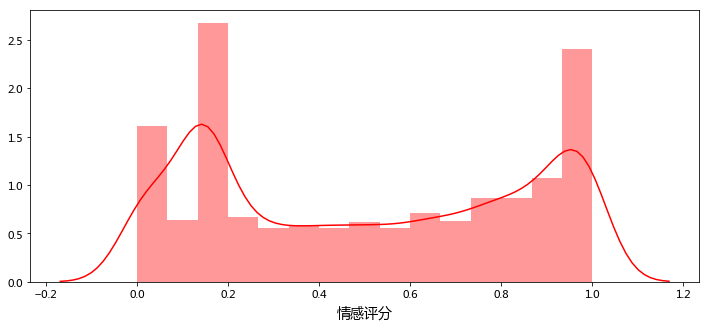

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize = (12,5))
sns.distplot(final_re['初评情感评分'],color = 'red')

plt.yticks(fontsize=11)
plt.xticks(fontsize=11)

ax.set_xlabel('情感评分', fontsize=14)

In [248]:
final_re.groupby('品牌')['初评情感评分'].median().reset_index()

,品牌,初评情感评分
0,三个魔发匠,0.547250
1,有情生姜,0.630458
2,白云山敬修堂,0.573973
3,章光101,0.145513
4,霸王防脱,0.615317
